# SQLite Query Walkthrough 

SQLite Studio is a great database management system for its user-friendliness and simple syntax. In this section, we will go over how to use SQLite (and a tiny bit of Python) to clean and prepare our Vancouver crime [data set](https://geodash.vpd.ca/opendata/) for analysis.   

First thing first, let's create a new database titled *vancouver*. This is where we will store our data sets.  

Then we import our dataset *vancouver_crime_data* as a table named *crime*.

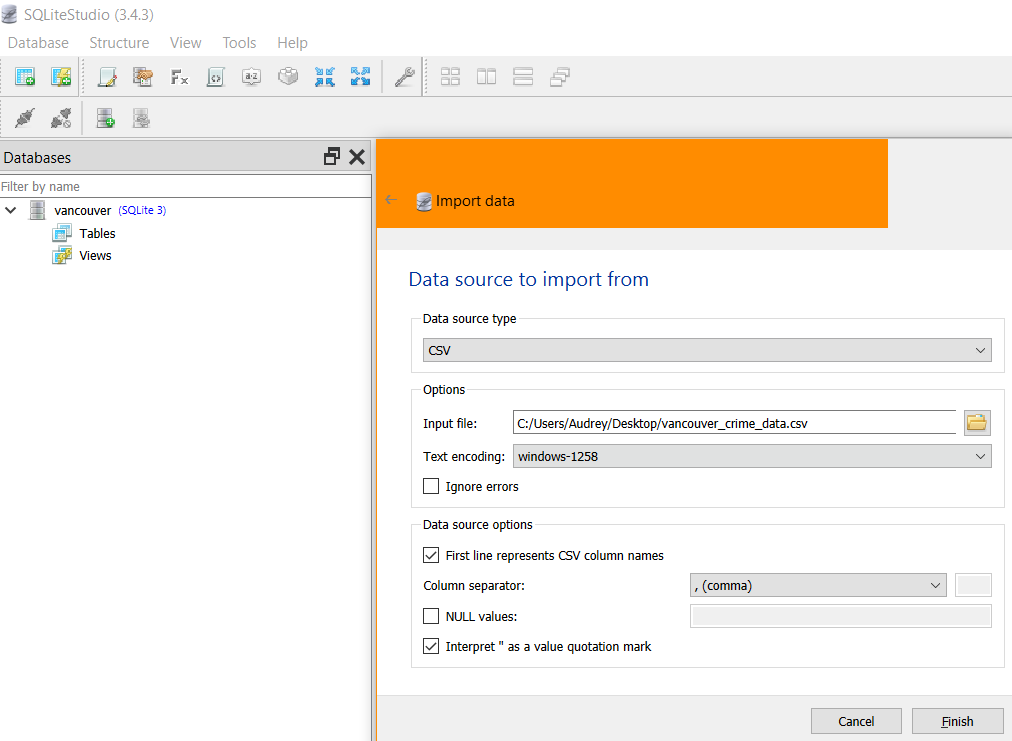

Below is what our table looks like.

```` sql
-- view the table
SELECT * FROM crime;
````

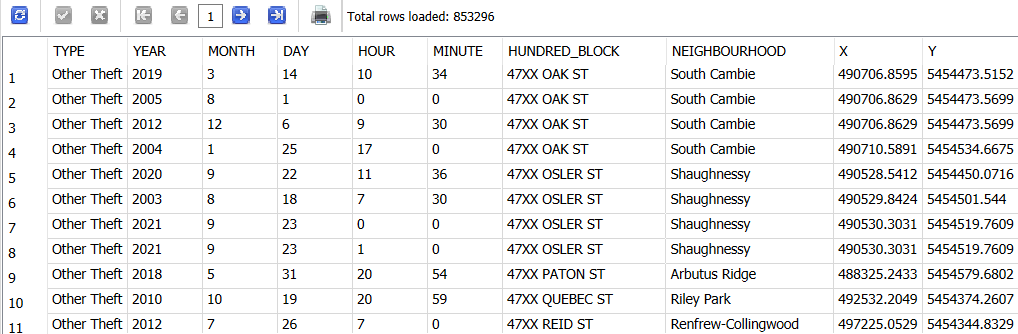

It looks like we have a large dataset, consisting of over 850k rows. Each one of these rows represents a crime that occured within the city of Vancouver in which the police was notified.

The column names are uppercase for some reason which is not advisable as it will make it harder for us to write and read our queries, so we'll make them all lowercase.  

We'll also drop the *MINUTE* column. When doing a crime trend analysis, knowing the minute a crime occured will not give us much meaningful insight. Regardless of that, minute is a way too small of a time measurement unit. It's difficult, if not impossible to pinpoint exactly what minute a crime happened, so the values in this column will be either unreliable (they are estimates) or a default value (value given when no estimates could have been made).  

Pinpointing the hour a crime happened can be difficult too. But it's much more reliable compared to minutes, and also give us meaningful information as to what part of the day a crime happened, so we are keeping the *HOUR* column.

``` sql
BEGIN TRANSACTION;

-- change column names
ALTER TABLE crime RENAME COLUMN TYPE TO type;
ALTER TABLE crime RENAME COLUMN YEAR TO year;
ALTER TABLE crime RENAME COLUMN MONTH TO month;
ALTER TABLE crime RENAME COLUMN DAY TO day;
ALTER TABLE crime RENAME COLUMN HOUR TO hour;
ALTER TABLE crime RENAME COLUMN HUNDRED_BLOCK TO block;
ALTER TABLE crime RENAME COLUMN NEIGHBOURHOOD TO hood;
ALTER TABLE crime RENAME COLUMN X TO UTM_x;
ALTER TABLE crime RENAME COLUMN Y TO UTM_y;

-- drop column
ALTER TABLE crime DROP COLUMN MINUTE;

END TRANSACTION;

-- view the table
SELECT * FROM crime;

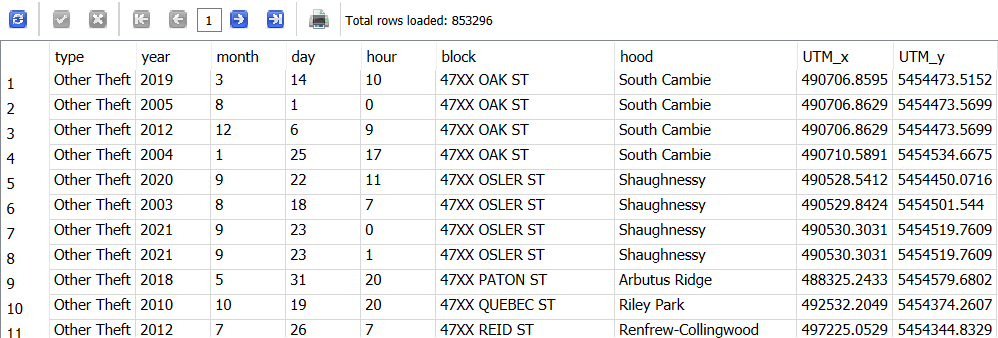

SQLite  has a dynamic data type system. In other words, it does not enforce column data types by default, allowing us to place values with different types in the same column.  

We can see this by double clicking on *crime*. Indeed, no data type is specified.

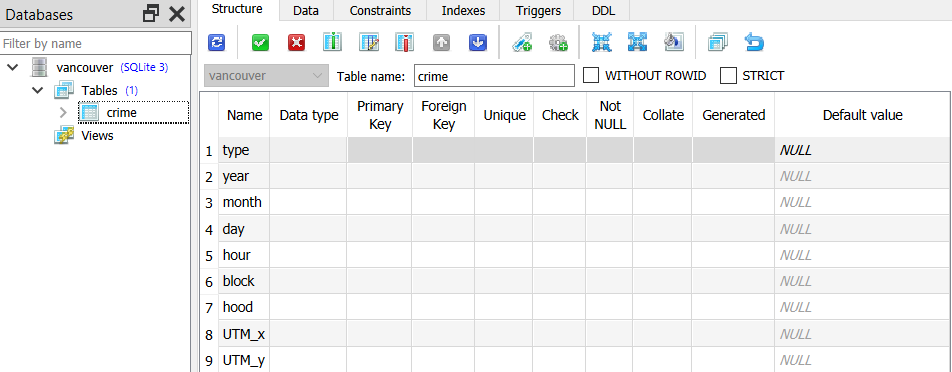

But we will go ahead and assign data types to some of the columns as it will make our job easier when filtering or aggregating values. We don't want our numeric values to be mistaken for text.

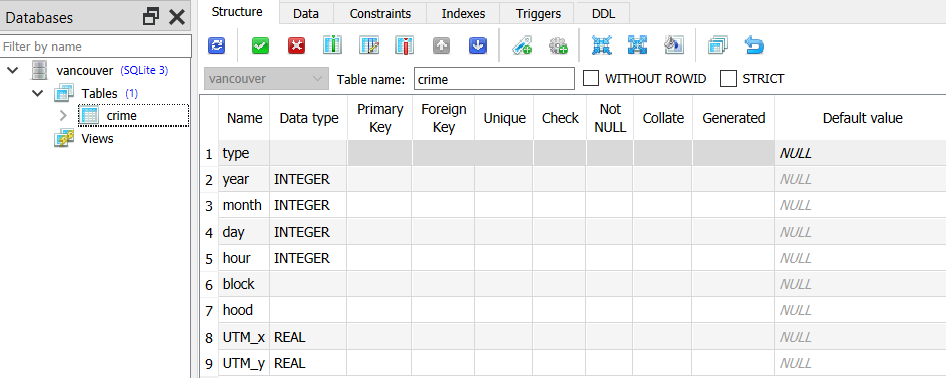

Now, we can dive deeper into the rows to see what kind of values we have.

``` sql
-- view distinct values
SELECT DISTINCT type FROM crime;
```

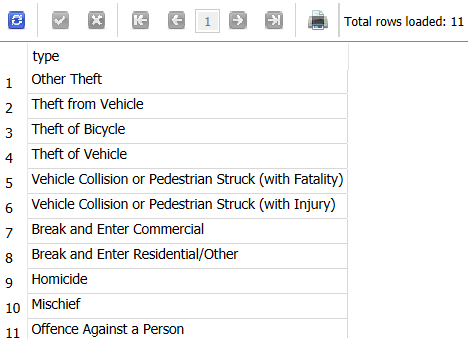

``` sql
SELECT DISTINCT year FROM crime ORDER BY year DESC;
```

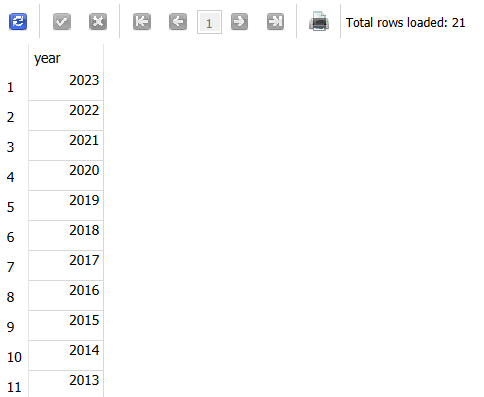

We see that we have every year from 2003 to 2023 in the *year* column. We want to analyze only the last decade so we will drop the previous years. We have to drop 2023 too, as data for this year will be incomplete since we are still in it.

``` sql
-- delete rows 
DELETE FROM crime WHERE year < 2011 OR year = 2023;
```

We know from the document our data set came with that coordinates for some crimes are not disclosed to protect the privacy of victims. Let's check how this looks like by filtering for null values.

``` sql
-- view null in UTM_x column
SELECT * FROM crime WHERE UTM_x IS NULL;
```

According to the query above, there are no null values. But don't let that deceive you because null values can sometimes be represented as empty strings or 0s. Let's check for those too.

``` sql
-- view '' in UTM_x column
SELECT * FROM crime WHERE UTM_x = '';
```

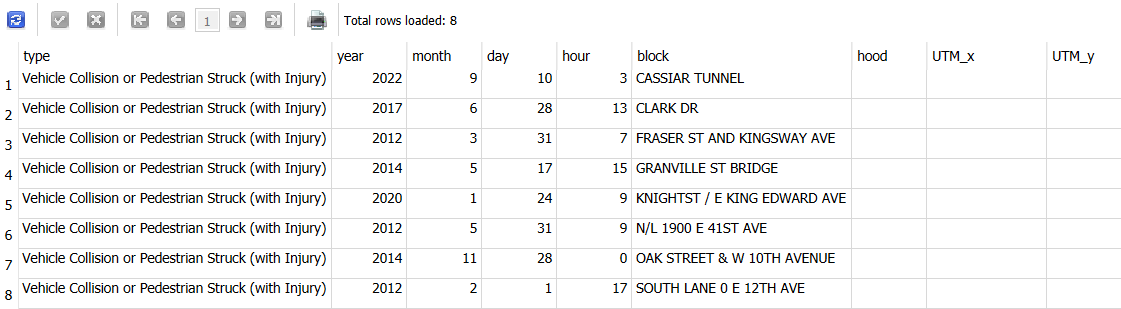

``` sql
-- view 0 in UTM_x column
SELECT * FROM crime WHERE UTM_x = 0;
```

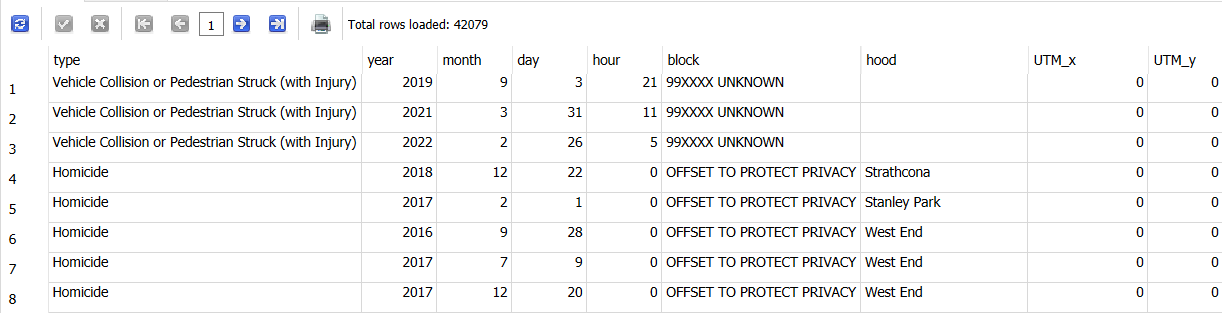

As you can see, there are clearly quite a lot of rows that lack coordinates. We want all the corresponding cells to be actual null values (not empty strings or 0s).

```sql
-- replace '' and 0 with null
BEGIN TRANSACTION;

UPDATE crime SET UTM_x = NULL WHERE UTM_x = '' OR UTM_x = 0;
UPDATE crime SET UTM_y = NULL WHERE UTM_y = '' OR UTM_y = 0;

END TRANSACTION;
```

We are done with *crime* table for now. It's time to create a new table where we have year by year population of Vancouver. We will insert the values found on the wikipedia page for [Vancouver](https://en.wikipedia.org/wiki/Vancouver#Demographics).

``` sql
-- create table
CREATE TABLE population (year, pop, rate);

-- insert rows
INSERT INTO population (year, pop) VALUES 
(2011, 603502),
(2016, 631486),
(2021, 662248);

SELECT * FROM population;
```

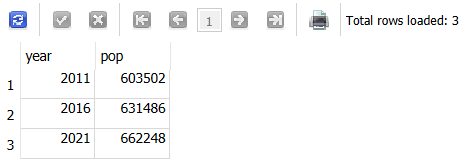

Since census data is collected once every 5 years, we only have population data for the years above. But not to worry, we can get a rough estimation of the population for the years in between.

To calculate the estimation, we will assume that the population increase of each year between two census dates are equal. The formula is simple; we substract 2011 population from 2016 population and divide the result by 5. This will give us the yearly average population increase (μ). When we add μ to 2011 population, we get the 2012 population estimate. When we add μ to 2012 estimate, we get the 2013 estimate and so forth.

In [17]:
a = [(((631486 - 603502) / 5) * x + 603502) for x in range(1,5)]
[round(y, 0) for y in a]

[609099.0, 614696.0, 620292.0, 625889.0]

Now let's apply the same formula for the 2016 and 2021 census years.

In [18]:
z = [(((662248 - 631486) / 5) * x + 631486) for x in range(1,5)]
[round(y, 0) for y in z]

[637638.0, 643791.0, 649943.0, 656096.0]

We also need to estimate the 2022 population which we will do by getting the average yearly increase between 2011 and 2021 and addind that value to 2021 population.

In [19]:
round(((max(z) - min(a)) / len(a + z)) + 662248)

668123

Again, these are rough estimates but since the growth rate of Vancouver in the last two decades have been stable, I think our values are reliable.  

We can insert the new values into *population* table.

``` sql
BEGIN TRANSACTION;

-- insert rows
INSERT INTO population (year, pop) VALUES
(2012, 609099), (2013, 614696), (2014, 620292), (2015, 625889),
(2017, 637638),(2018, 643791), (2019, 649943), (2020, 656096),
(2022, 668123);

END TRANSACTION;

-- view table as year ascending
SELECT * FROM population ORDER BY year ASC;
```

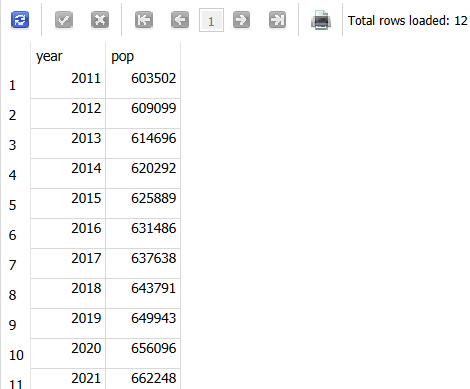

There is one more table to create. We will group the *year* and *type* values from *crime* table and insert them into our new table *crime_rate*. As the name suggests, we will use this table to calculate crime rates.  

A quick note: We are calculating rates because as opposed to absolute numbers, they allow us to control for population when comparing different locations or times. Now, rate probably won't tell us much for this project as the population difference between 2011 and 2022 is minimal. But it's still good practice to use rates because someone who looks at our data may want to compare Vancouver with another city or Vancouver from many decades ago.

``` sql
BEGIN TRANSACTION;

-- create table, rows grouped by year and type, add count value as column
CREATE TABLE crime_rate AS
SELECT type, year, COUNT(*) AS count
FROM crime
GROUP BY type, year;

END TRANSACTION;

SELECT * FROM crime_rate;
```

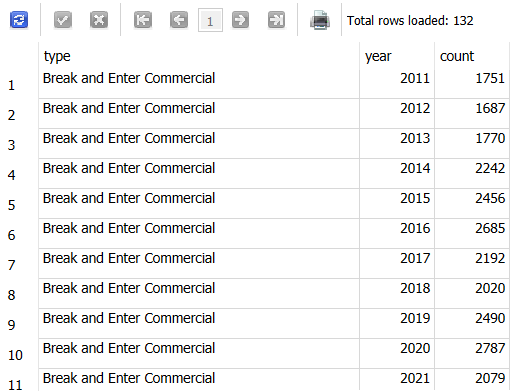

Let's join *population* and *crime_rate*.

``` sql
BEGIN TRANSACTION;

CREATE TABLE crime_rate2 AS

-- join tables 
SELECT crime_rate.*, population.pop AS van_pop
FROM crime_rate
NATURAL JOIN population;

END TRANSACTION;

SELECT * FROM crime_rate2;
```

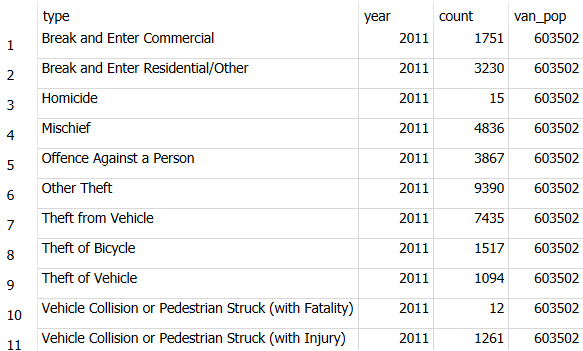

Finally, we can write a formula to calculate the rate (by 100k).  Our new *rate_capita* column tells us how many crimes happen per 100,000 thousand people when controlled by *year* and *type*.  

```sql
BEGIN TRANSACTION;

CREATE TABLE crime_rate3 AS

-- calculate per capita
SELECT *,
((count * 1.0) / van_pop) * 100000 AS rate_capita
FROM crime_rate2;

END TRANSACTION;

SELECT * FROM crime_rate3;
```

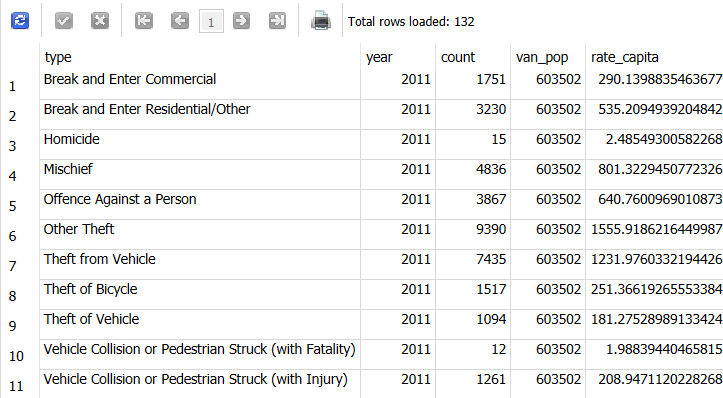

One final edit, we can delete *crime_rate* and *crime_rate2* as they were temporary. After that let's rename *crime_rate3* back to *crime_rate* so it looks better.

```sql
DROP TABLE crime_rate; 
DROP TABLE crime_rate2;

ALTER TABLE crime_rate3 RENAME TO crime_rate;
```

Congrats! We have succesfully created 3 tables.

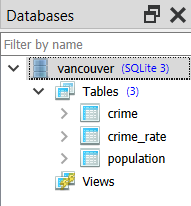

Let's export two of our tables that we will use to create a dashboard, *crime* and 'crime_rate', as .csv files. And that's it, we are done with SQLite!

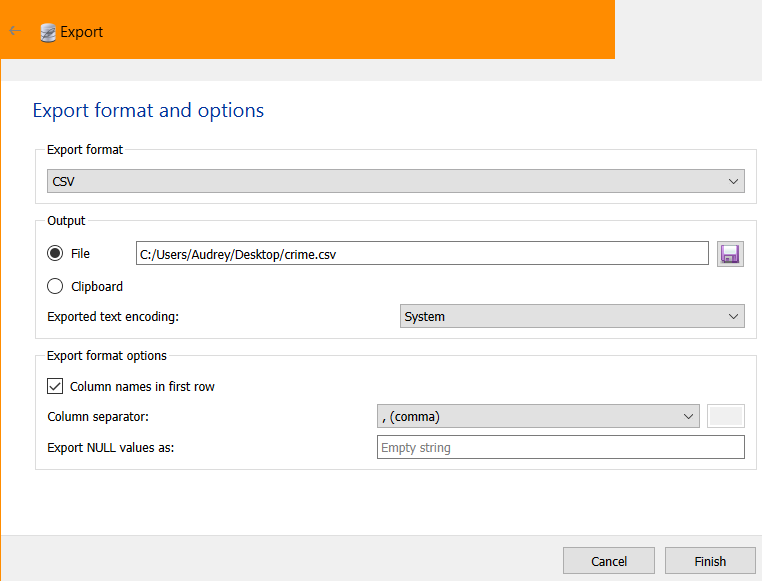

As we mentioned before, we will need to use a little bit of Python for the next section. The coordinates in our data set are based on UTM, a projected coordinate system. In simple terms, the coordinates are based on a 2D projection of earth. Unfortunately Tableau doesn't recognize UTM for mapping (as far as I know. The MAKEPOINT function allegedly makes UTM coordinates functional but when I tried that, Tableau would crash).

Tableau uses WGS84, a geographic coordinate system, in which the coordinates are based on a 3D earth. This is the default standard for latitudes and longitudes and it's what GPS, Google Maps and many similar applications use by default. So now we will convert the UTM columns to WGS84 latitude and longitude in python, using **utm**, a library whose sole purpose is this conversion.  

In [20]:
import pandas as pd
import utm

We open the *crime* table we just imported out of SQLite and create a copy of it in which the rows with a null value under the *UTM_x* column are removed. We need to do this as the utm functions don't work when there are null values or values that are out of a specified range.

In [21]:
df = pd.read_csv(r'C:\Users\Audrey\Desktop\crime.csv')
dfc = df.copy()
dfc = dfc.dropna(axis = 0, subset = ['UTM_x'])

The **utm.tolatlong** function takes four parameters: easting, northing, zone number and zone letter. *UTM_x* and *UTM_y* correspond to easting and northing. As for the zone number and letter for the [region](https://maps.omniscale.com/en/openstreetmap/epsg-32610) where Vancouver lies in, the values are 10 and N.

In [22]:
# convert utm columns to lat/long columns
def convert(dfc):
    lat, lon = utm.to_latlon(dfc["UTM_x"], dfc["UTM_y"], 10, 'N')
    return pd.Series({"lat": lat, "lon": lon})
# merge lat/long columns to dataframe
newdf = dfc.merge(dfc.apply(convert, axis=1), left_index= True, right_index= True)

We now have lat/long columns alongside utm columns in *newdf*. But remember that we had excluded null values so let's stitch them back up. We will do this by selecting only the null values from the original data frame and then concatenating it with *newdf*. (I'm aware that this is the long way around of joining two tables but I prefer this as it's faster than merge function).

In [23]:
dfn = df[df['UTM_x'].isna()]
df = pd.concat([dfn, newdf], axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468900 entries, 0 to 468899
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  468900 non-null  int64  
 1   type        468900 non-null  object 
 2   year        468900 non-null  int64  
 3   month       468900 non-null  int64  
 4   day         468900 non-null  int64  
 5   hour        468900 non-null  int64  
 6   block       468899 non-null  object 
 7   hood        468842 non-null  object 
 8   UTM_x       426813 non-null  float64
 9   UTM_y       426813 non-null  float64
 10  lat         426813 non-null  float64
 11  lon         426813 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 46.5+ MB


Everyting looks to be in order. There are no missing rows and we have all the columns we need, so let's export the final dataframe *df* and move onto Tableau!

In [24]:
df.to_csv('crime.csv')